# Genetic drift

Natural selection can push allele frequencies around,
but what if it isn't?
Allele frequencies still change, due to the randomness inherent in who reproduces
and who doesn't.
Or, what if natural selection is acting -- how important is the randomness?

## The simplest model

As usual, let's start simple.
Suppose in a population of size $N$ an allele is at frequency $p = k/N$.
On average, we'd expect it to *still* be at frequency $p$ in the next generation.
Let's see how that works out.

In [1]:
%load_ext slim_magic

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, SVG

In [2]:
%%slim_stats_reps_cstack 30 --out drift
// set up a single locus simulation of drift
initialize()
{
    initializeMutationRate(0);
    initializeMutationType("m1", 0.5, "f", 0.0);
    initializeGenomicElementType("g1", c(m1), c(1.0));
    initializeGenomicElement(g1, 0, 0);
    initializeRecombinationRate(0);
    suppressWarnings(T);
}

1 {
    sim.addSubpop("p1", 500);
    // add mutation to half the genomes from the first population
    target = sample(p1.genomes, p1.individualCount);
    target.addNewMutation(m1,0, 0);
    log = sim.createLogFile("/dev/stdout", logInterval=1);
    log.addGeneration();
    log.addCustomColumn("p", "mean(p1.individuals.countOfMutationsOfType(m1))/2;");
}

500 late() {
    sim.simulationFinished();
}

Here's those allele frequencies through time:

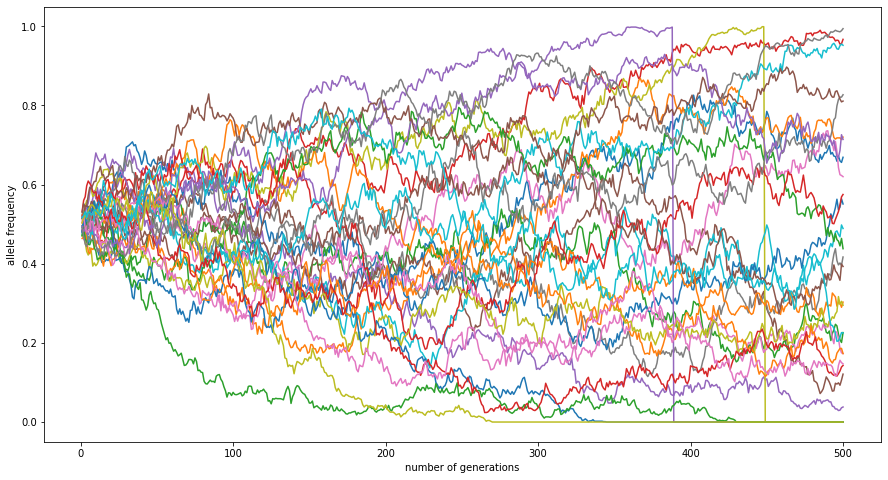

In [3]:
drift.set_axis([f"p{k}" for k in range(drift.shape[1])], axis=1, inplace=True)

fig, ax = plt.subplots(figsize=(15, 8))
ax.set_xlabel("number of generations")
ax.set_ylabel("allele frequency")
for col in drift:
    ax.plot(drift.index, drift[col])

And, here's the standard deviation of those allele frequences through time:

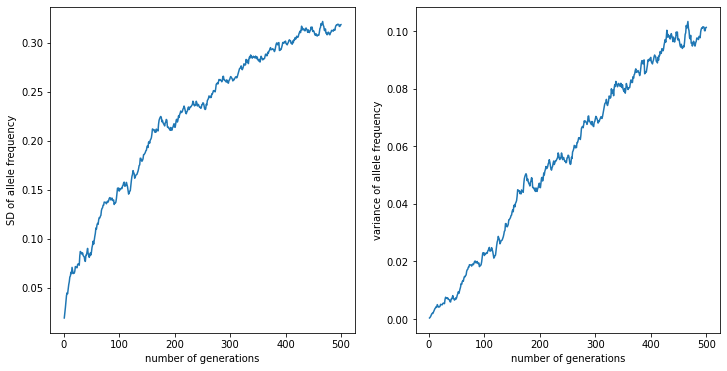

In [4]:
p = np.array(drift)
sds = np.array([
    np.std(x) for x in p
])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(drift.index, sds)
ax1.set_xlabel("number of generations")
ax1.set_ylabel("SD of allele frequency")
ax2.plot(drift.index, sds**2)
ax2.set_xlabel("number of generations")
ax2.set_ylabel("variance of allele frequency");

## Okay, now the theory

Why's that?
Well, think about how the WF model works:
each offspring genome is produced by a uniformly randomly selected parent genome
(independently of everything else).
So, if $X_t$ is the number of copies of the allele we're counting at generation $t$,
then

$$
   X_{t+1} \sim \text{Binomial}(2N, X_t/2N) .
$$

In other words, we get the next generation "by binomial sampling".
Since the allele frequency is $P_t = X_t/2N$,
then given this,

$$\begin{aligned}
  \mathbb{E}[X_{t+1}] &= X_t \\
  \mathbf{var}[X_{t+1}] &= X_t (1 - X_t / 2N) ,
\end{aligned}$$

and so

$$\begin{aligned}
  \mathbb{E}[P_{t+1}] &= P_t \\
  \mathbf{var}[P_{t+1}] &= P_t (1 - P_t) / 2N .
\end{aligned}$$

If we assume that the frequency doesn't change too much over time,
then

$$\begin{aligned}
  \mathbb{E}[P_{t}] &= P_0 \\
  \mathbf{var}[P_{t}] &\approx t P_0 (1 - P_0) / 2N .
\end{aligned}$$

### Exercise:

Put the "theory" lines on the plots above.

# Mutation-drift equilibrium

The next question is: mutation adds genetic variation and drift removes it;
where do these balance? We'll look at this a few different ways.
First, a simulation:

In [5]:
%%slim_stats_reps_cstack 3 --out het
// set up a single locus simulation of drift
initialize()
{
    initializeMutationRate(1e-8);
    initializeMutationType("m1", 0.5, "f", 0.0);
    initializeGenomicElementType("g1", c(m1), c(1.0));
    initializeGenomicElement(g1, 0, 9999999);
    initializeRecombinationRate(1e-8);
    suppressWarnings(T);
}

1 {
    sim.addSubpop("p1", 500);
    // add mutation to half the genomes from the first population
    target = sample(p1.genomes, p1.individualCount);
    target.addNewMutation(m1,0, 0);
    log = sim.createLogFile("/dev/stdout", logInterval=1);
    log.addGeneration();
    log.addCustomColumn(
        "pi",
        "calcHeterozygosity(p1.individuals.genomes);"
    );
}

5000 late() {
    sim.simulationFinished();
}

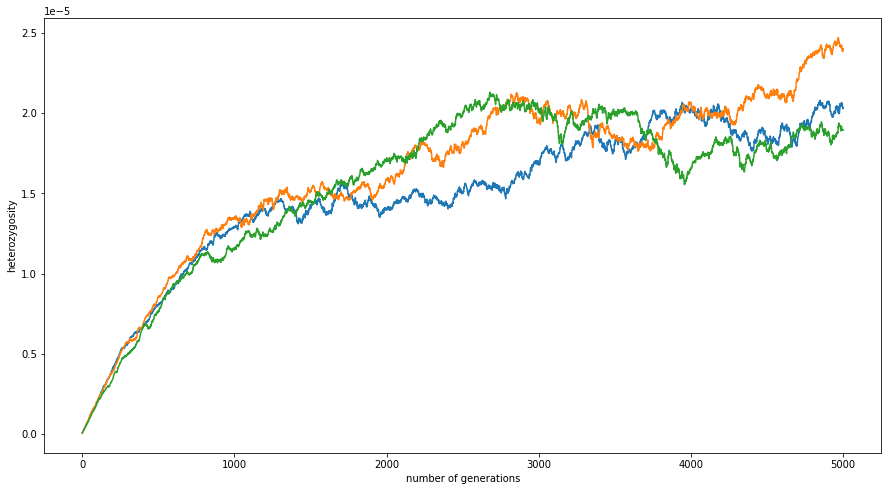

In [6]:
het.set_axis([f"pi{k}" for k in range(het.shape[1])], axis=1, inplace=True)

fig, ax = plt.subplots(figsize=(15, 8))
ax.set_xlabel("number of generations")
ax.set_ylabel("heterozygosity")
for col in het:
    ax.plot(het.index, het[col])

To understand what that's showing us, here's what the SLiM function `calcHeterozygosity( )` does:
```
	length = sim.chromosome.lastPosition + 1;
	p = genomes.mutationFrequenciesInGenomes(muts);
	heterozygosity = 2 * sum(p * (1 - p)) / length;
	return heterozygosity;
```

This is the expected proportion of positions
at which two randomly chosen genomes differ.
In this simulation, that number equilibrates around $2 \times 10^{-5}$.
What do we expect?

## A note on notation

Above we've used "heterozygosity" to refer to a *statistic* calculated
from a set of genomes, that summarizes the amount of genetic diversity within those genomes.
This is sometimes called $\pi$.
Population genetics literature is not known for having consistent notation,
or defining its terms,
and indeed, $\pi$ is also often used to refer to the *expected value* of that statistic
under some model or other.
This confuses the actual value of the statistic calculated from a dataset
with its mean under some model;
actually, the value of the statistic computed from data produced by that model
will be random, and vary about the expected value
to some extent.

We can see this in the plots above:
there is noisiness in the trajectories,
and the replicates don't converge to the same value,
although they do wander around some value.
Our goal next is to understand this equilibrium value -
the long-term mean.
We'll refer to the statistic one would compute from the data
with a Roman letter, $h$,
and the expected value under a model with a greek one: $\mathbb{E}[h] = \pi$.

## Theory, again

Consider that definition of (expected) heterozygosity -
the expected number of positions at which two randomly chosen genomes differ.
When do two genomes differ at a given position?
Well, they differ either if their parents differ,
or if they don't and there's been a mutation while producing one of their genomes.
The  chance the two parents differ is just the heterozygosity in the previous generation,
except for the case in which the two genomes actually share a common parent.
We can use this basic observation to write a recursion for $\pi_t$,
the expected heterozygosity at time $t$.

Let's take a simple model of mutation - at each site there are two alleles,
and each mutates to the other with probability $\mu$.
Then, the probability that siblings differ at a site is $2 \mu (1-\mu)$.
Since the probability under the Wright-Fisher model that the two genomes are siblings
at a given site is $1/2N$,
the previous paragraph says that

$$
    \pi_{t+1} = 
        \frac{1}{2N} 2 \mu (1-\mu)
        + \left(1 - \frac{1}{2N} \right)
          \left\{
              \pi_t (1 - 2 \mu (1-\mu))
              + (1 - \pi_t) 2 \mu (1-\mu)
          \right\} .
$$

Here the terms are:
share parents and mutation;
parents differ and no mutation;
parents do not differ and mutation.
Rearranging, this is

$$
    \pi_{t+1} = 
        2 \mu (1-\mu)
        + \left(1 - \frac{1}{2N} \right)
              (1 - 4 \mu (1-\mu))
              \pi_t .
$$

To solve for stationarity,
let's ask what value of $\pi_*$ would have $\pi_t = \pi_{t+1} = \pi_*$.
Solving for $\pi_*$, we get

$$\begin{aligned}
    \pi_* &=
    \frac{
        4 N \mu (1 - \mu)
    }{
        1 + 4 \mu (1 - \mu)(2 N - 1)
    } \\
    &\approx 4 N \mu .
\end{aligned}$$

**Exercise:**
Add the theory curves to the plot above.

# Fixation rates

The next aspect of drift is:
what proportion of new mutations end up fixing in the population?
For neutral mutations, the answer is easy:
imagine the population at the time when a new, neutral mutation occurs
at a given position.
That neutral mutation has equal chance of occurring in any of the $2N$ genomes.
Now imagine in the far future - eventually, everyone in the future will
descend from just a single one of these genomes.
The chance that the mutation picks that one lucky "ultimate ancestor"
is just $1/2N$.

So, if we write $p_f(s)$ for the probability of fixation
of a new mutation with selection coefficient $s$,
then in a population of diploid size $N$,

$$
  p_f(0) = \frac{1}{2N} .
$$

**Exercise:** Check this, with a simulation.